# Phase 2 v4 Unified Training Monitor

This notebook monitors the training progress of `scripts/train_phase2_v4_unified.py`.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Config
log_file = "../logs/training_metrics_v4_unified.csv"
window = 20  # Smoother window for high-res analysis

## 1. Standard Training Loss (Total, CE, KD)

This view shows the overall convergence and the balance between Grammar (CE) and Logic (KD).


Loaded 119 steps.


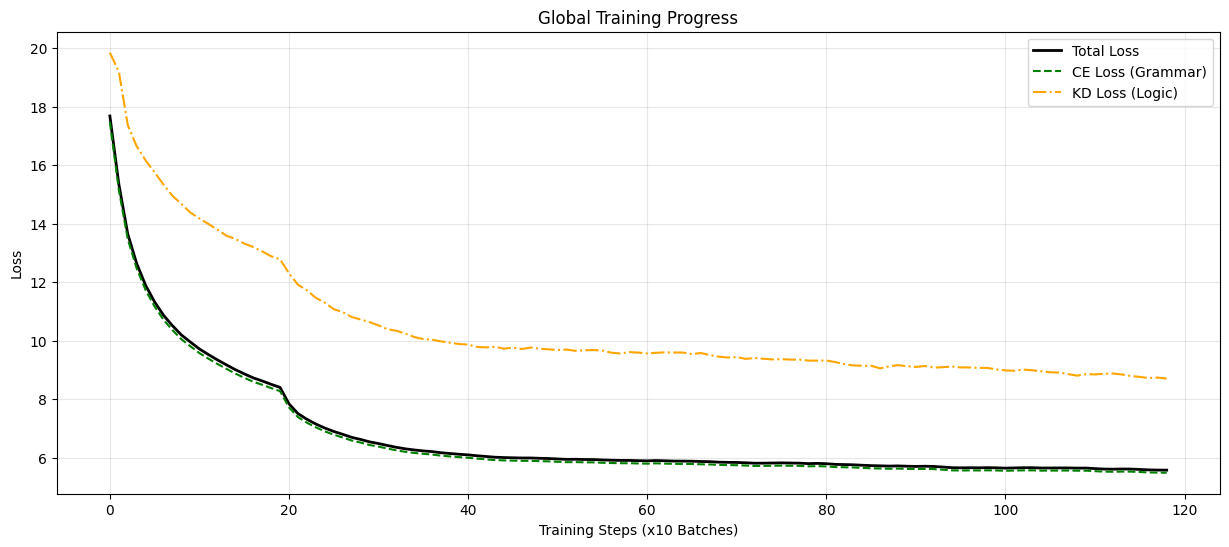

In [33]:
if os.path.exists(log_file):
    try:
        df = pd.read_csv(log_file)
        print(f"Loaded {len(df)} steps.")

        # Smoothing
        df["Total_Smooth"] = df["Total_Loss"].rolling(window, min_periods=1).mean()
        df["CE_Smooth"] = df["CE"].rolling(window, min_periods=1).mean()
        df["KD_Smooth"] = df["KD"].rolling(window, min_periods=1).mean()

        plt.figure(figsize=(15, 6))
        plt.plot(df["Total_Smooth"], label="Total Loss", color="black", linewidth=2)
        plt.plot(
            df["CE_Smooth"], label="CE Loss (Grammar)", color="green", linestyle="--"
        )
        plt.plot(
            df["KD_Smooth"], label="KD Loss (Logic)", color="orange", linestyle="-."
        )
        plt.xlabel("Training Steps (x10 Batches)")
        plt.ylabel("Loss")
        plt.title("Global Training Progress")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")
else:
    print("Log file not found.")

## 2. Quantum Component Analysis (Mag & Phase)

This view analyzes the internal quantum state:

- **Mag Loss (Confidence/Salience):** How confident the model is.
- **Phase Loss (Structure/Uncertainty):** How well it models ambiguity.


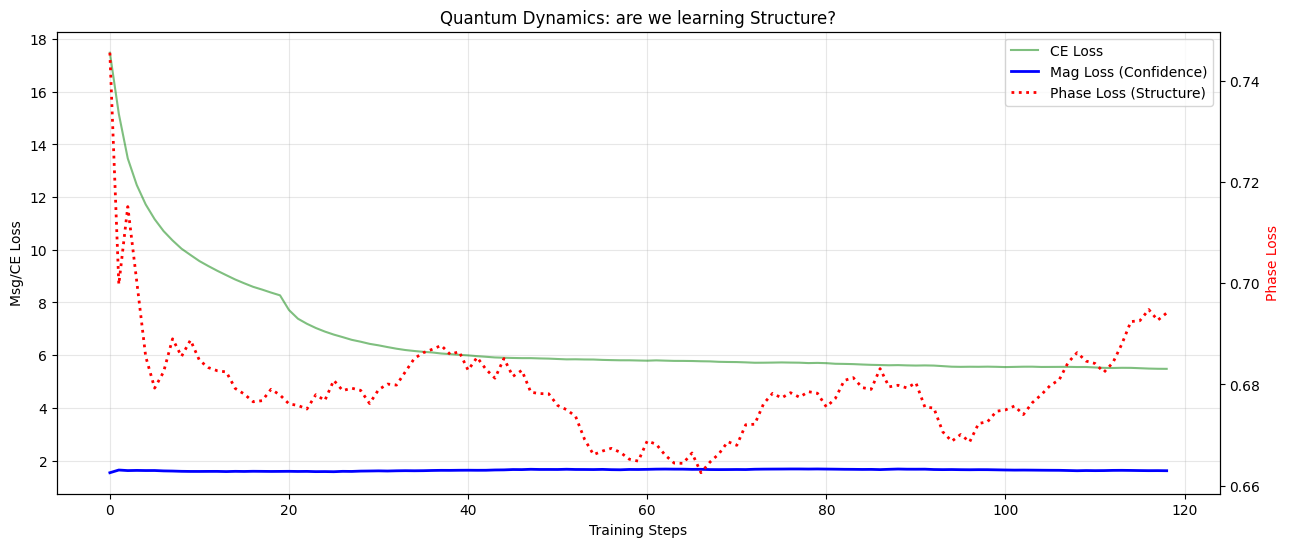

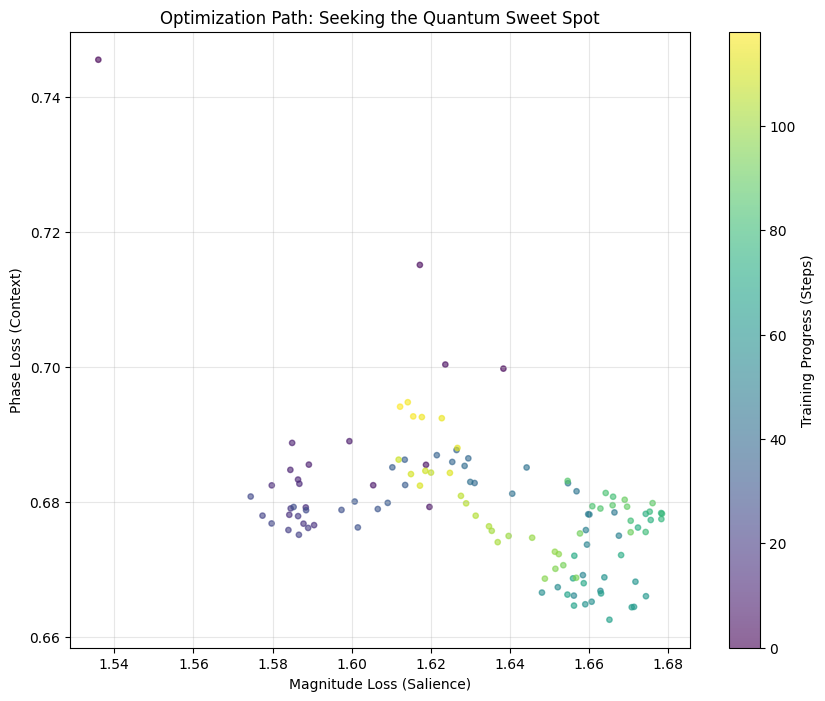

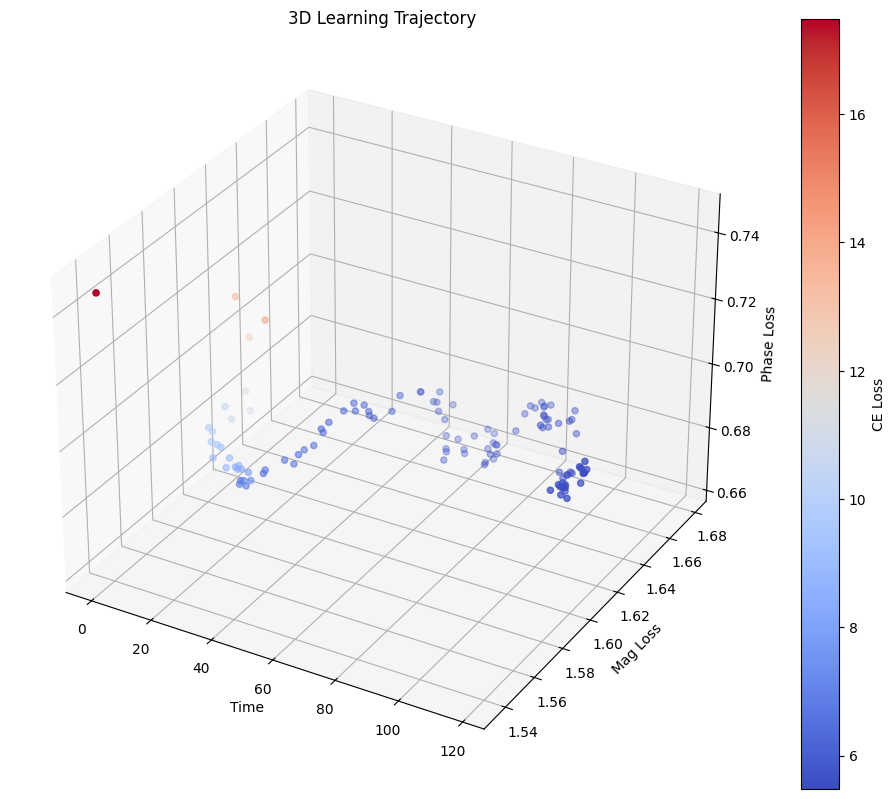

In [34]:
if os.path.exists(log_file):
    try:
        # Smoothing Quantum Metrics
        df["Mag_Smooth"] = df["Mag"].rolling(window, min_periods=1).mean()
        df["Phase_Smooth"] = df["Phase"].rolling(window, min_periods=1).mean()
        df["Batch_Index"] = df.index

        # --- PLOT 2A: QUANTUM LOSS CURVES ---
        fig, ax1 = plt.subplots(figsize=(15, 6))
        ax1.plot(df["CE_Smooth"], label="CE Loss", color="green", alpha=0.5)
        ax1.plot(
            df["Mag_Smooth"], label="Mag Loss (Confidence)", color="blue", linewidth=2
        )
        ax1.set_xlabel("Training Steps")
        ax1.set_ylabel("Msg/CE Loss")
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.plot(
            df["Phase_Smooth"],
            label="Phase Loss (Structure)",
            color="red",
            linestyle=":",
            linewidth=2,
        )
        ax2.set_ylabel("Phase Loss", color="red")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
        plt.title("Quantum Dynamics: are we learning Structure?")
        plt.show()

        # --- PLOT 2B: PHASE-MAG CORRELATION ---
        plt.figure(figsize=(10, 8))
        sc = plt.scatter(
            df["Mag_Smooth"],
            df["Phase_Smooth"],
            c=df["Batch_Index"],
            cmap="viridis",
            alpha=0.6,
            s=15,
        )
        plt.colorbar(sc, label="Training Progress (Steps)")
        plt.xlabel("Magnitude Loss (Salience)")
        plt.ylabel("Phase Loss (Context)")
        plt.title("Optimization Path: Seeking the Quantum Sweet Spot")
        plt.grid(True, alpha=0.3)
        plt.show()

        # --- PLOT 2C: 3D TRAJECTORY ---
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection="3d")
        p = ax.scatter(
            df["Batch_Index"],
            df["Mag_Smooth"],
            df["Phase_Smooth"],
            c=df["CE_Smooth"],
            cmap="coolwarm",
            s=20,
        )
        ax.set_xlabel("Time")
        ax.set_ylabel("Mag Loss")
        ax.set_zlabel("Phase Loss")
        fig.colorbar(p, label="CE Loss")
        plt.title("3D Learning Trajectory")
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

In [35]:
# TEST CHECKPOINT CELL

import torch
import sys
import os
from transformers import AutoTokenizer

# Add root to path so we can import indra
sys.path.append(os.path.abspath(".."))
from indra.models.quantum_model_v2 import IndraQuantumPhase2

# --- CONFIG ---
checkpoint_path = "../checkpoints/phase2_v4_unified/checkpoint_v4_epoch_1.pt"
prompts = [
    "The future of AI is",
    "Quantum mechanics explains",
    "### Instruction:\nWhat is the capital of France?\n\n### Response:\n",
]
device = "cuda" if torch.cuda.is_available() else "cpu"
# --------------

if os.path.exists(checkpoint_path):
    print(f"Loading {checkpoint_path}...")
    try:
        # Initialize Model (Masking fixed architecture)
        model = IndraQuantumPhase2(32000, 128).to(device)
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()

        tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

        for p in prompts:
            input_ids = tokenizer.encode(p, return_tensors="pt").to(device)
            print(f"\nPrompt: {p.strip()}")
            print("Output: ", end="")

            # Generate
            with torch.no_grad():
                output_ids = input_ids.clone()
                for _ in range(50):
                    # pass Mask=None for inference
                    logits, _, _ = model(output_ids, attention_mask=None)
                    next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                    output_ids = torch.cat([output_ids, next_token], dim=1)
                    print(tokenizer.decode(next_token[0]), end="", flush=True)
                    if next_token.item() == tokenizer.eos_token_id:
                        break
            print()

    except Exception as e:
        print(f"Error running model: {e}")
else:
    print(f"Checkpoint not found: {checkpoint_path}")

Loading ../checkpoints/phase2_v4_unified/checkpoint_v4_epoch_1.pt...


C:\Users\dpanc\AppData\Local\Temp\ipykernel_34272\521418368.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)



Prompt: The future of AI is
Output: a
###Responseas--@-@-@-@-@--@--@--@--@-@-@---@----@-@--@---

Prompt: Quantum mechanics explains
Output: 
<s><s>==================
<s><s>
<s><s><s><s><s><s><s><s><s><s>============

Prompt: ### Instruction:
What is the capital of France?

### Response:
Output: S--------@------------------------------
---@-----
